<a href="https://www.kaggle.com/code/bhavinmoriya/statistics-in-finance?scriptVersionId=124748849" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats as st
from datetime import datetime as dt, timedelta as td

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Fat tailed distributions

It is very often that returns are fat tailed.

In [2]:
end = dt.today()
start = end - td(days=3000)
df = web.get_data_stooq('AMZN', start, end)[['Close']]
df

,Close
Date,
2023-04-05,101.1000
2023-04-04,103.9500
2023-04-03,102.4100
2023-03-31,103.2900
2023-03-30,102.0000
...,...
2015-01-26,15.4830
2015-01-23,15.6195
2015-01-22,15.5160


In [3]:
log_ret = np.log(df / df.shift())
mu, sigma = log_ret.mean(), log_ret.std()
# df.shift()

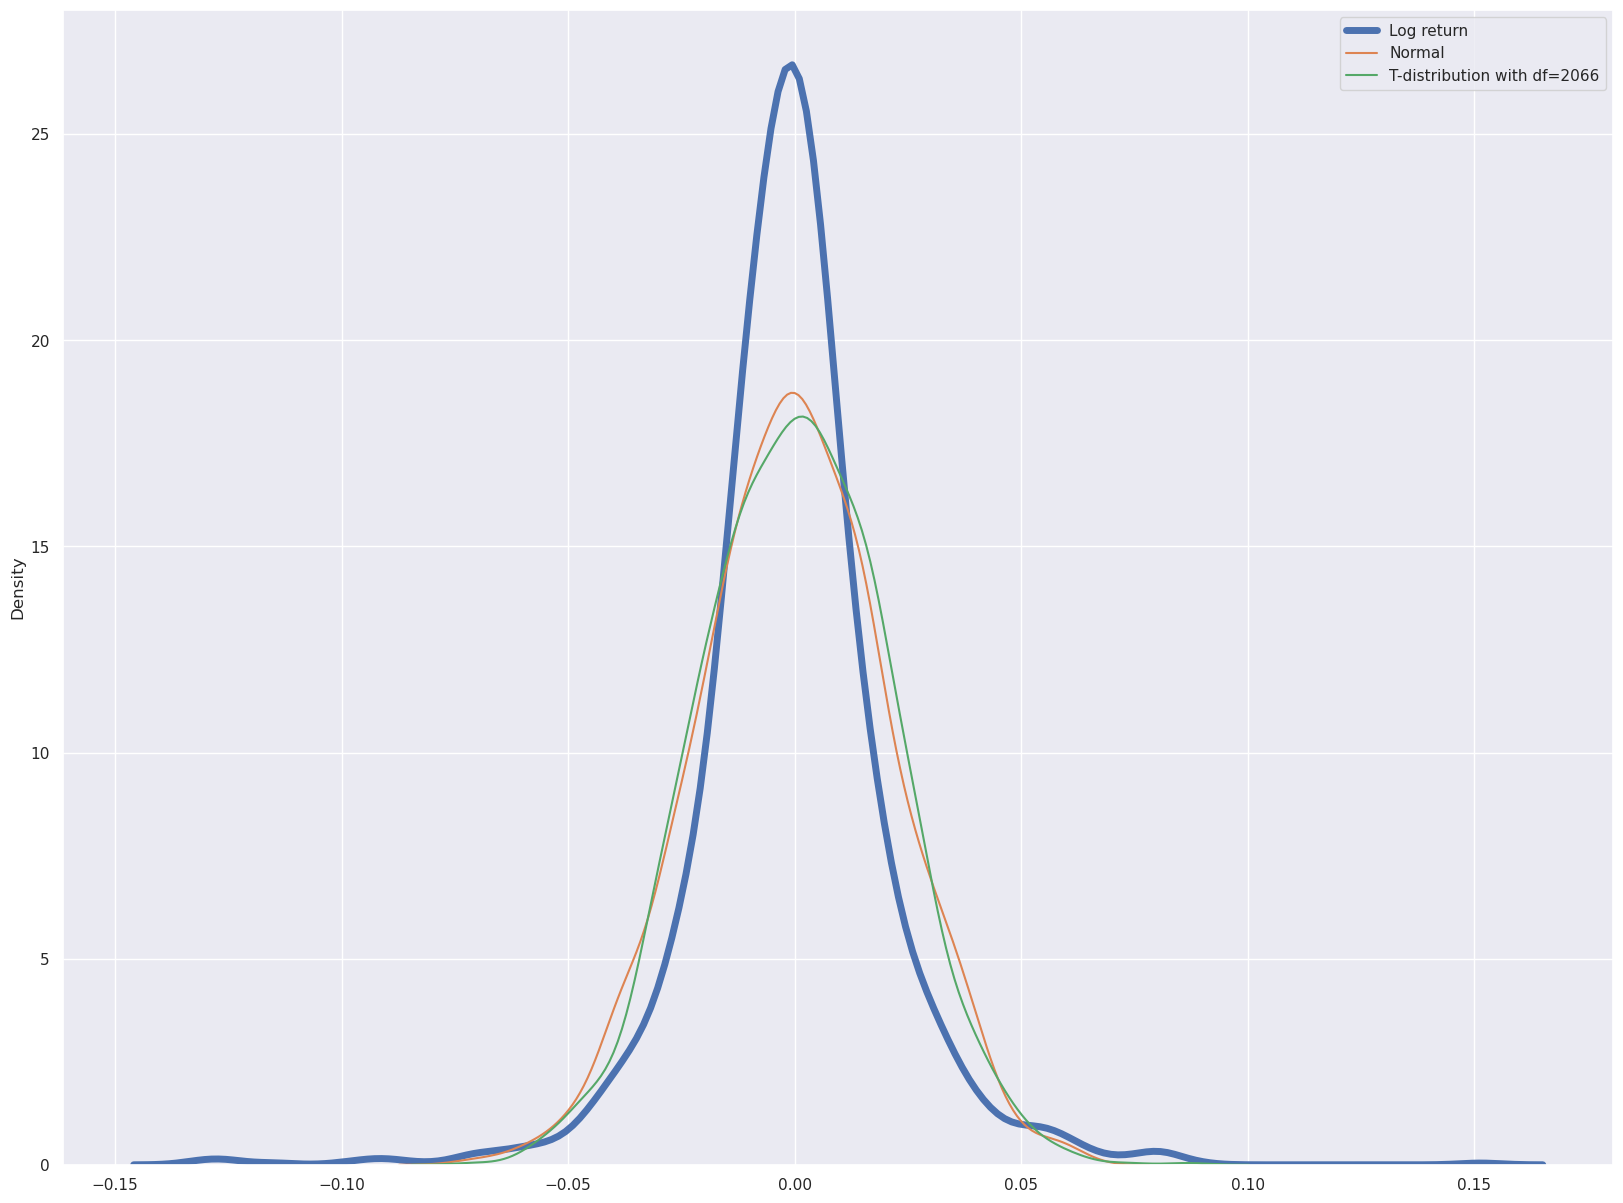

In [4]:
plt.figure(figsize=(20,15))
sns.kdeplot(log_ret, label='Log return', lw=5)
sns.kdeplot(st.norm.rvs(loc=mu, scale=sigma, size=len(log_ret)-1), label='Normal')
sns.kdeplot(st.t.rvs(loc=mu, scale=sigma, size=len(log_ret)-1, df=len(log_ret)-2), 
            label=f'T-distribution with df={len(log_ret)-2}')
plt.legend()

Observe that,
- Log returns have fatter tails compare to Normal Distribution.
- Normal and T-distribution seem to be overlapping (reason is degree of freedom is at lease 35)

We shall do QQ test to see if log_returns are normal. We shall see that it tails will produce points which are off the diagonal line.

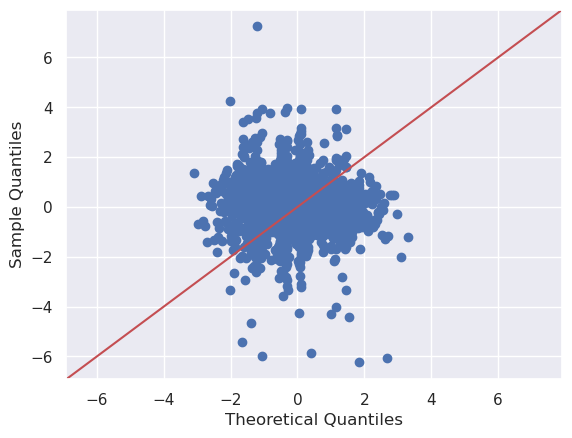

In [5]:
import statsmodels.api as sm
sm.qqplot((log_ret - mu)/sigma, line='45');

In [6]:
k = log_ret.kurt()[0]
# k=3-1
if k > 3:
    print('Fat tailed distribution')
elif k == 3:
    print('Normal Dist')
else:
#     print("adfjaksdf")
    pass

Fat tailed distribution


This actually shows that the log returns are not normal.

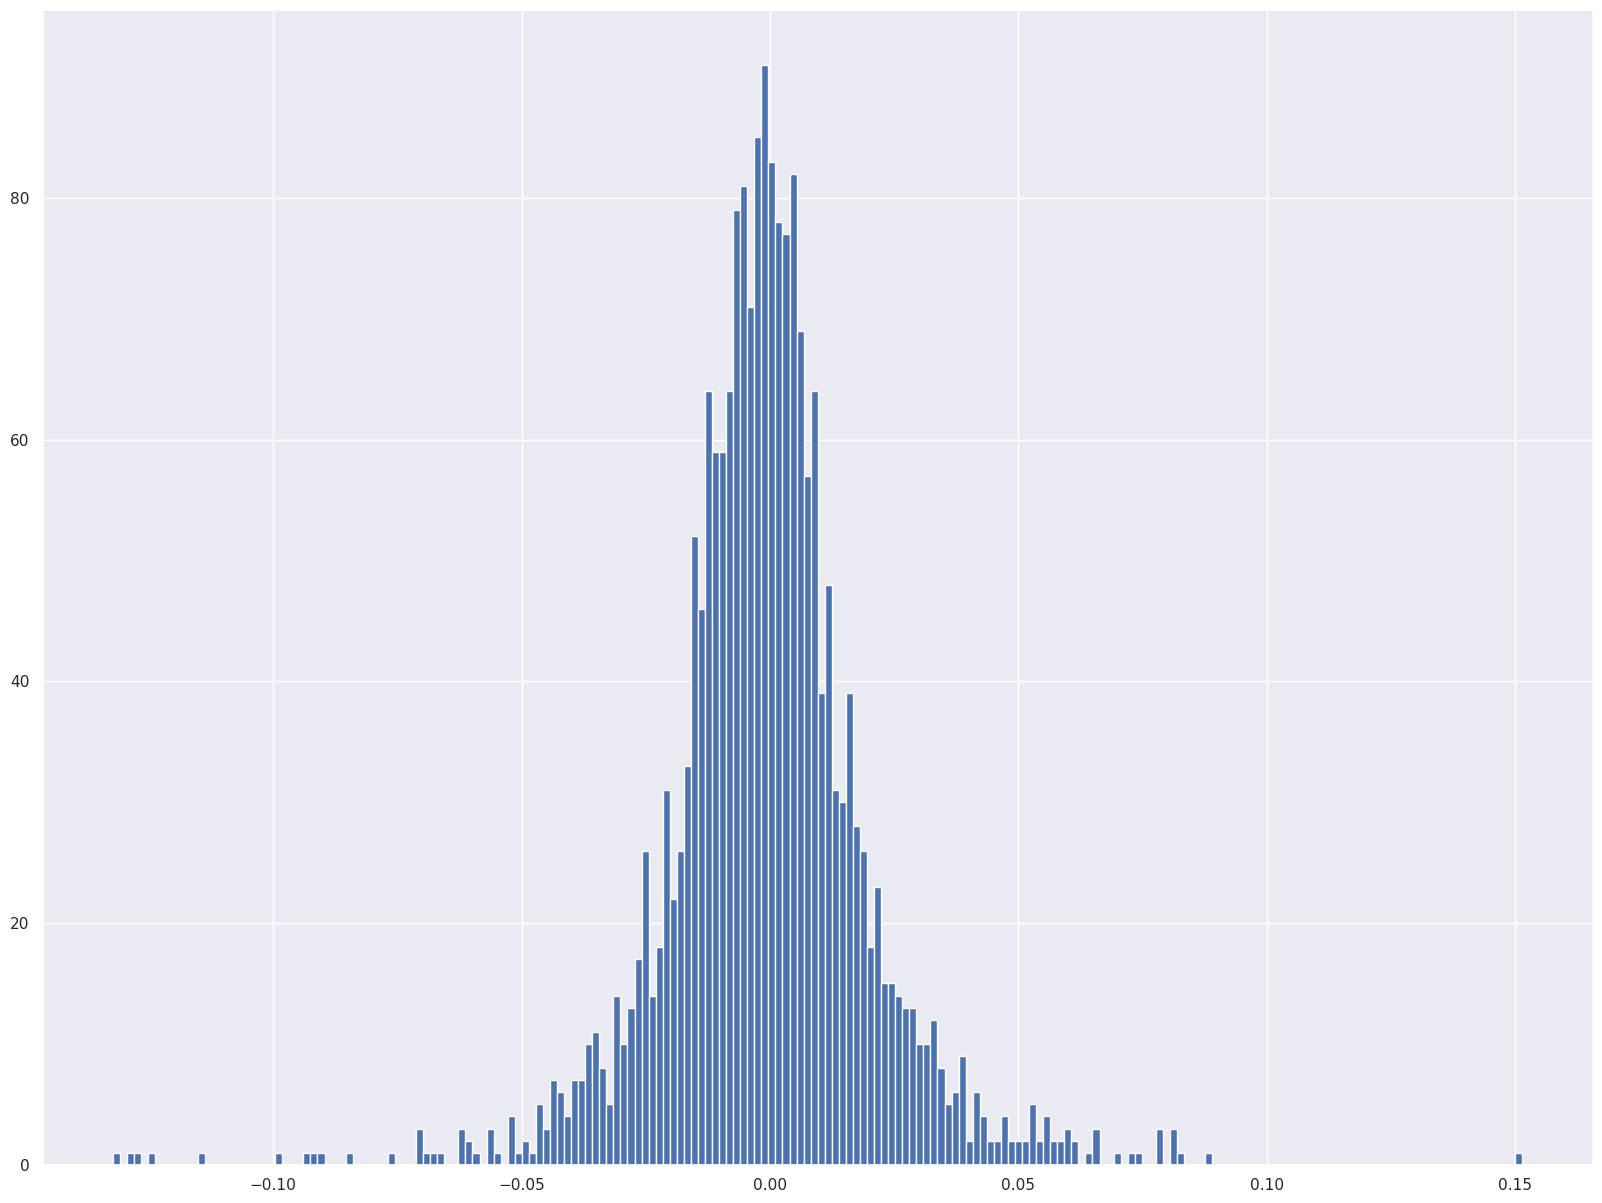

In [7]:
plt.figure(figsize=(20,15))
plt.hist(log_ret, bins=200);

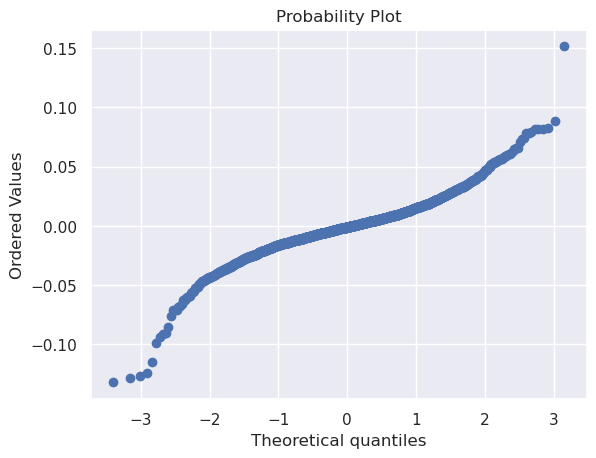

In [8]:
st.probplot(log_ret.values.flatten(), dist='norm', plot=plt);
# plt.plot([0,1],[0,1])

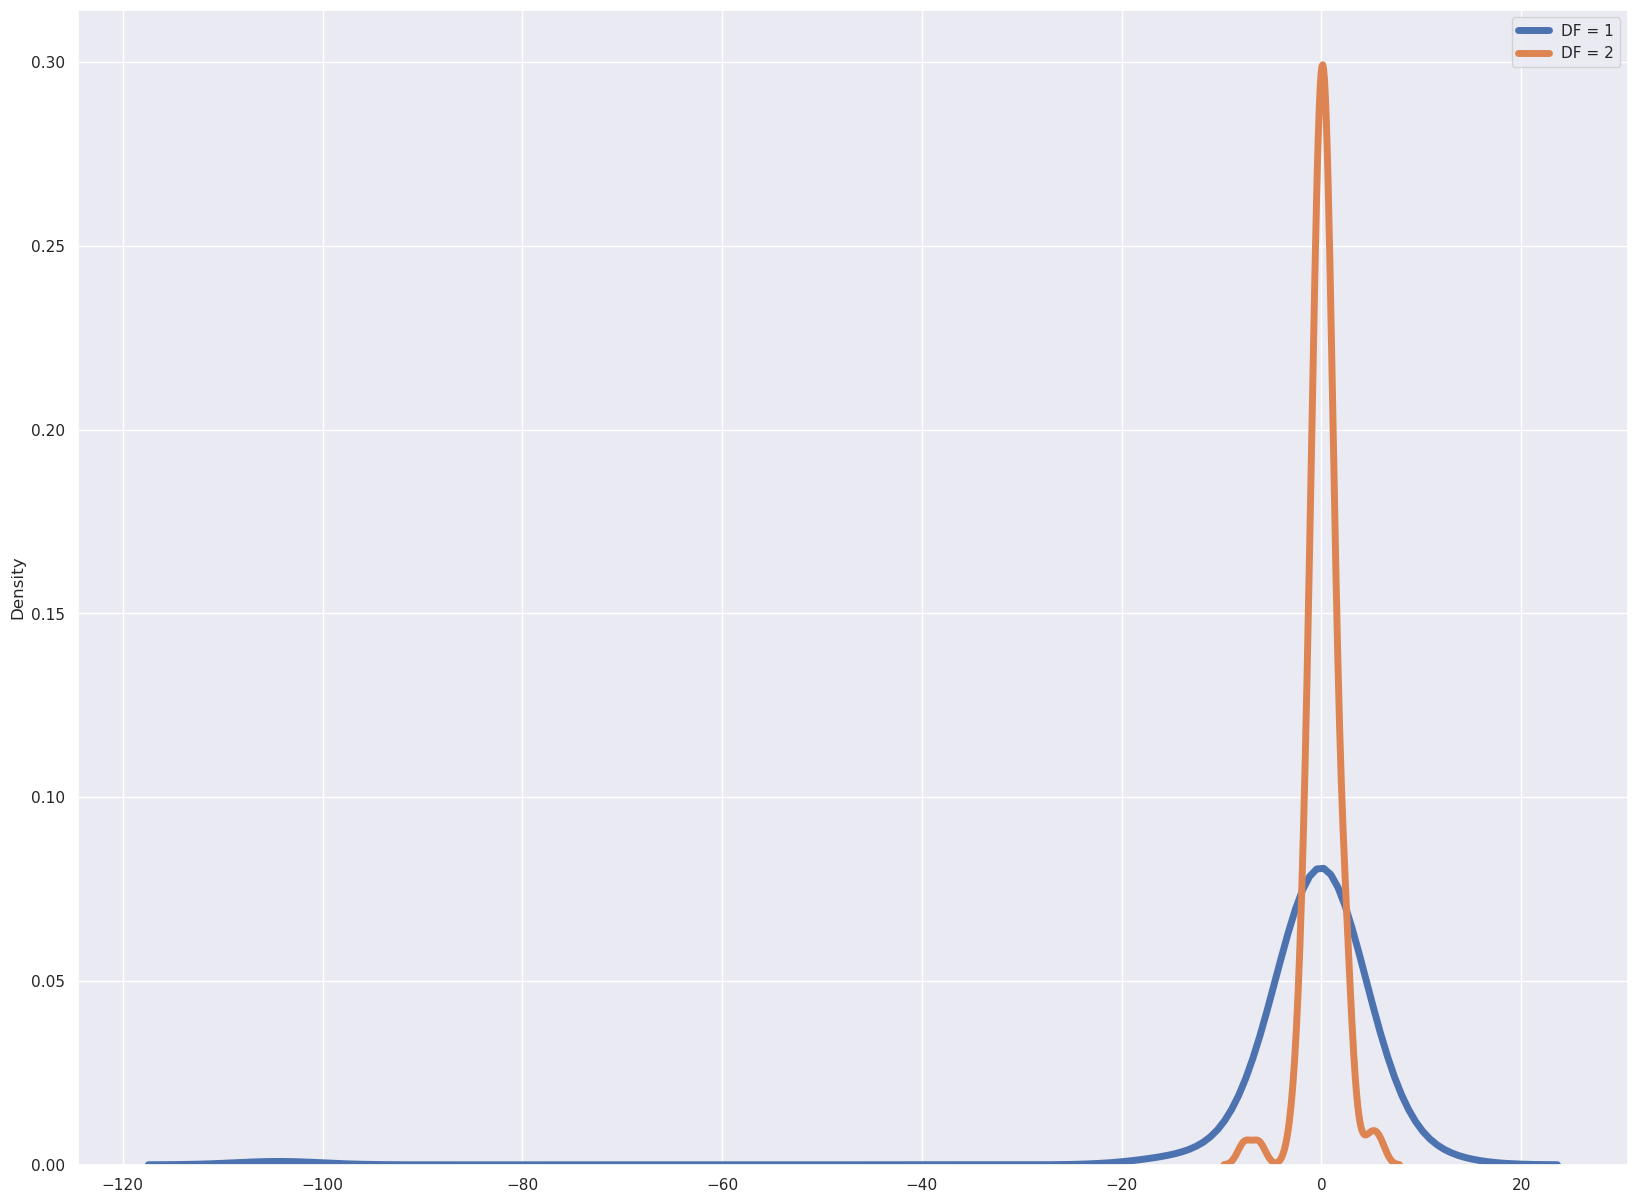

In [9]:
plt.figure(figsize=(20,15))
for i in range(1,3):
    sns.kdeplot(st.t.rvs(size=100, df=i), label=f'DF = {i}', lw=5)
plt.legend()


# Autocorrelation of a time series

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

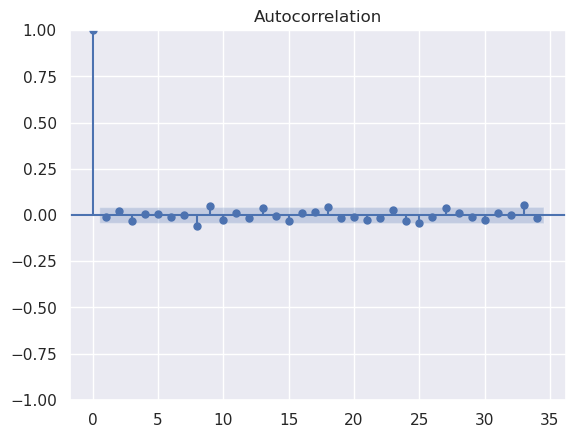

In [11]:
plot_acf(log_ret.dropna());

Returns seem to be stationary. There seem to be very mild correlation at some points though. We will confirm same from the following plot of return - which seem to be moving around zero with roughly same variance (that is called stationary).

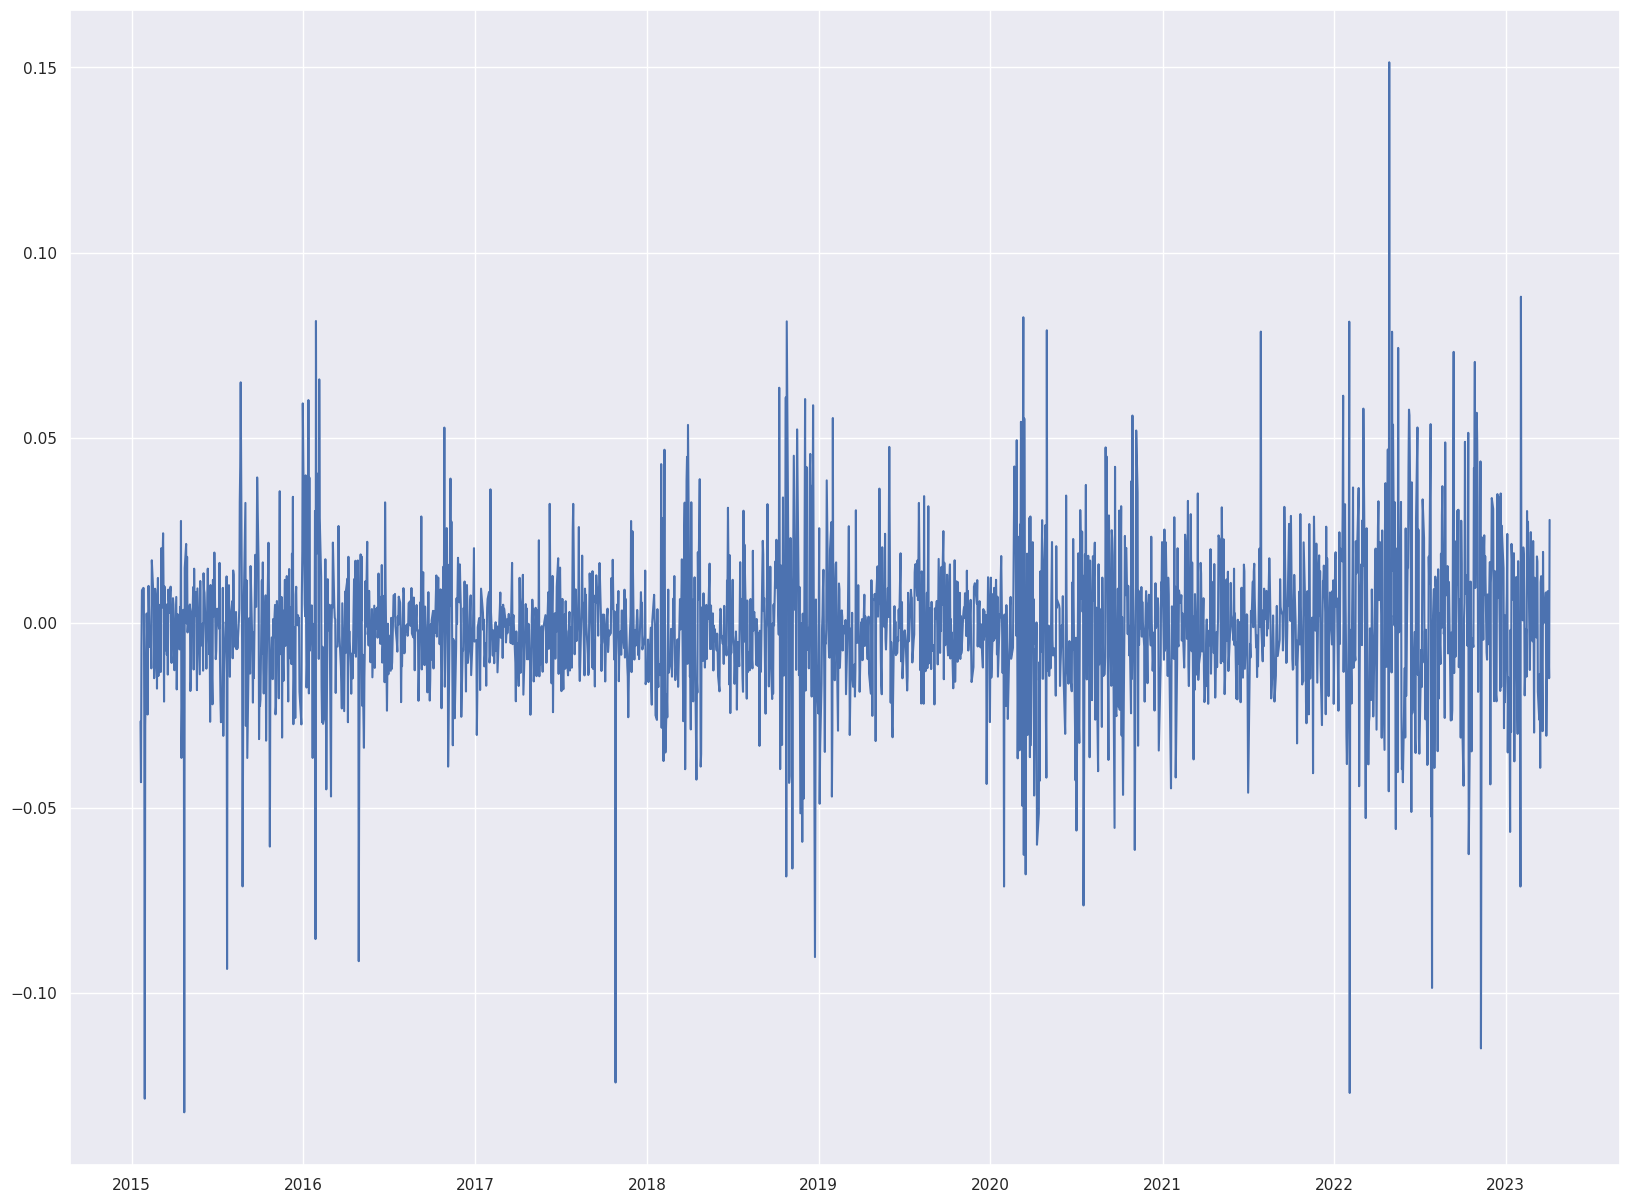

In [12]:
plt.figure(figsize=(20,15))
plt.plot(log_ret)

Now, let us try to construct some autocorrelated data.

In [13]:
x = [1,2,3]
for i in range(1000):
    x.append(.1*x[-1] + .2*x[-2] + .7*x[-3])
x = np.array(x)

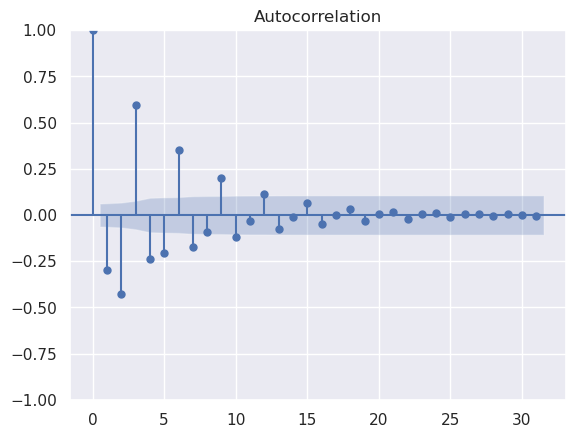

In [14]:
plot_acf(x);
# plt.axhline(.7)

So until 12th lag we see there is a correlation. Here is awesome article : https://real-statistics.com/time-series-analysis/stochastic-processes/autocorrelation-function/#:~:text=Definitions,variance%20of%20the%20stochastic%20process.

In [15]:
sp = web.get_data_stooq('^spx', start, end)[['Close']]
sp
sp_ret = (np.log(sp / sp.shift())
.dropna()
         )
sp_ret

,Close
Date,
2023-04-04,0.002495
2023-04-03,0.005814
2023-03-31,-0.003692
2023-03-30,-0.014333
2023-03-29,-0.005699
...,...
2015-01-26,0.013478
2015-01-23,-0.002565
2015-01-22,0.005507


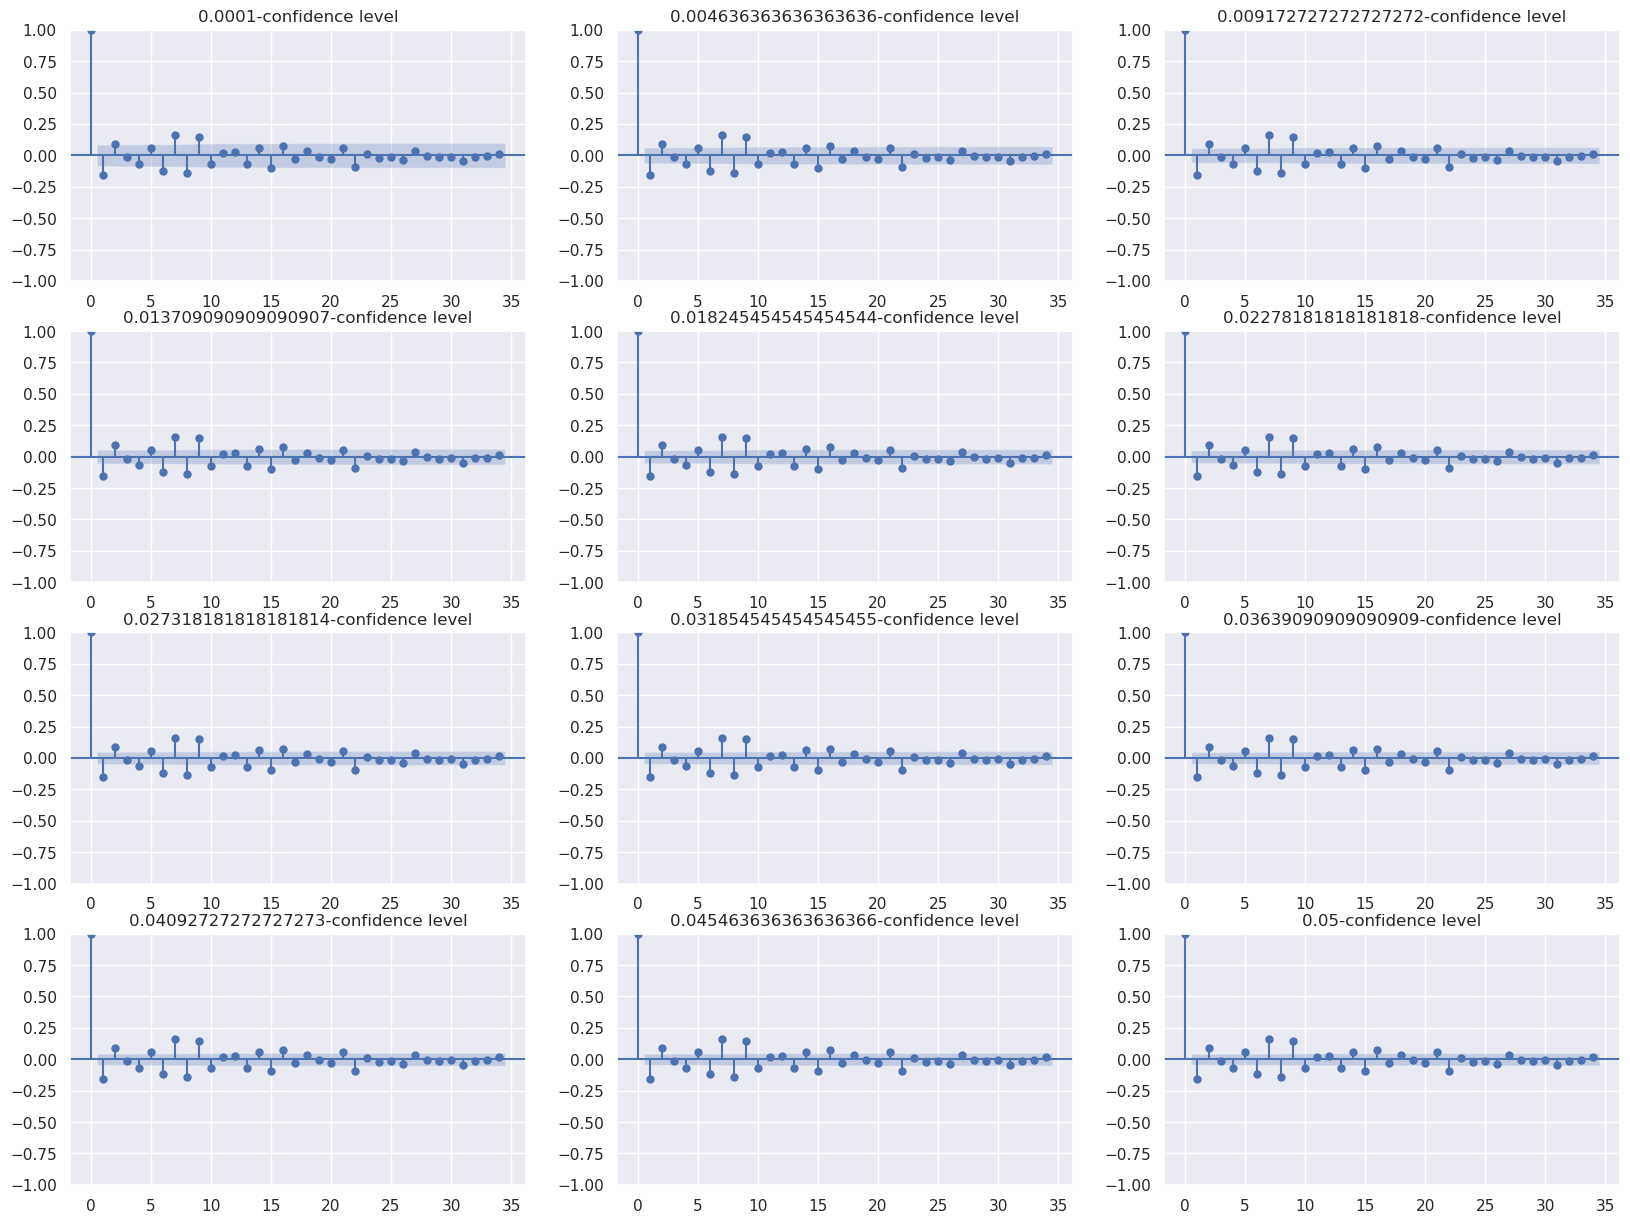

In [16]:
fig, ax = plt.subplots(4,3, figsize=(20,15))
ax = ax.flatten()
confidence = np.linspace(.0001,.05, 12)
for j,i in enumerate(confidence):
    
#     print(confidence)
    plot_acf(sp_ret,
        alpha=i,
            ax=ax[j],
            title=f'{i}-confidence level');
#     plt.legend()

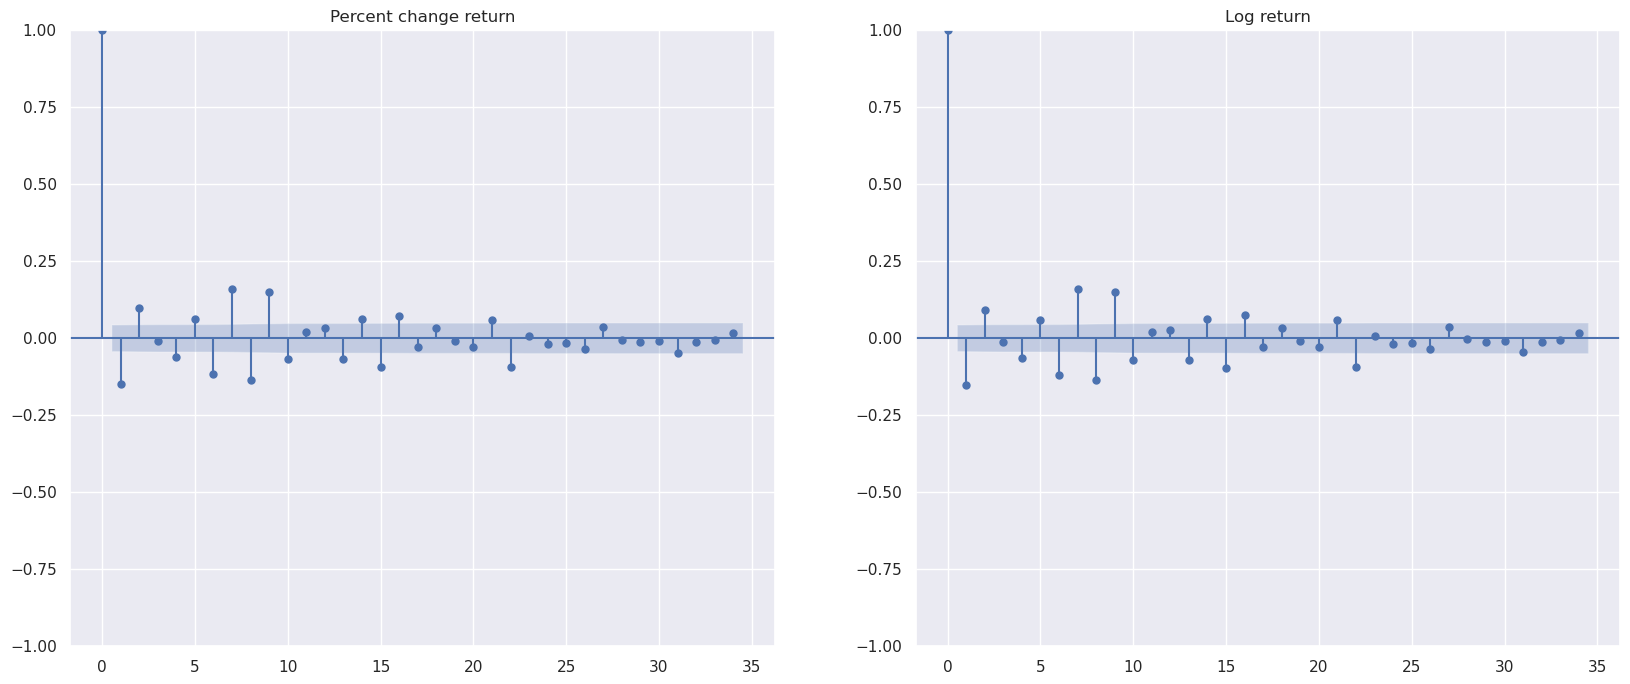

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
plot_acf(sp.pct_change().dropna(), ax=ax[0], title='Percent change return');
# plt.subplot(212)
plot_acf(sp_ret, ax=ax[1], title='Log return');

As we can see both returns gives same autocorrelation.

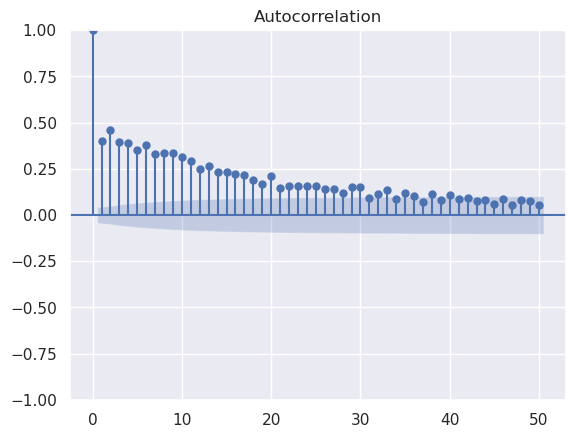

In [18]:
plot_acf(np.abs(sp_ret),
        lags=50);

As expected decays slowly to zero and all lags are significantly correlated.